# Hydrogel Indentation Test Case

In this notebook, we develop a test case for hydrogel particle indentation test with two opposite sphere indenter. We first assume the indenter is rigid.

In [1]:
########################## Colab support not available ##########################
# If you run this notebook from colab, run this cell first
# import os
# codepath = '/content/ShElastic'
# if not os.path.exists(codepath):
#     !git clone https://github.com/yfwang09/ShElastic.git 
#     !pip install pyshtools==4.6.2
# os.chdir(os.path.join(codepath, 'examples'))

In [2]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize, Bounds, brute, approx_fprime
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os
from itertools import permutations
import pyshtools

sys.path.append('..')
from shelastic.shutil import SphCoord_to_CartCoord, CartCoord_to_SphCoord, GLQCartCoord
from shelastic.shutil import SHCilmToVector, SHVectorToCilm, SHVec2mesh, SHmesh2Vec
from shelastic.shutil import TransMat, l_coeffs, m_coeffs, LM_list, lmk2K, K2lmk
from shelastic.shbv   import generate_submat, Uvec2Tvec, Tvec2Uvec
from shelastic.shvis  import plotfv, vismesh, visSHVec, visSH3d
from shelastic.sphere_utils import loadCoeffs, arbitrary_force, Ur_interp
from shelastic.sphere_utils import usurf2umesh, dumesh_dus, usurf2vec
from shelastic.sphere_utils import Tvec2Tres, usurf2dr2, calculateTfv, genSmat, genLmat, grad_usurf2dr2

## Set up parameters for calculation

In [51]:
######### Do not change below unless you know what you are doing ###############
# Data file name
shapename = 'indent'
plot_figure = True

# Material properties
mu0 = 1401/3; mu = 1
nu0 = nu = 0.499
R = 3.7
r = 0.5
d = 0.3

# Spherical Harmonics Analysis Settings
lJmax = 60; lKmax = lJmax; lmax_plot = 60;

# settings for loading \hat{U}, \hat{T} coefficients
Cmat, Dmat = loadCoeffs(mu0, nu0, lJmax, 'reg')

Integrating modes to a matrix
11163 11163
Integrating modes to a matrix
11163 11163


In [52]:
#### load the full and sub matrix ####
import time
import scipy.sparse as spm
from scipy.io import loadmat, savemat
from shelastic.shelastic import calSmode
from shelastic.shbv import generate_submat

ticT = time.time()
shtype = 'reg'
modepath = '../shelastic/default_modes'
Tmodes = loadmat(os.path.join(modepath, 'Tmodes.mat'))
Cmat_1 = generate_submat(Tmodes, mu, nu, lKmax, lJmax, shtype=shtype).tocsc()
Umodes = loadmat(os.path.join(modepath, 'Umodes.mat'))
Dmat_1 = generate_submat(Umodes, mu, nu, lKmax, lJmax, shtype=shtype).tocsc()
Smodes = loadmat(os.path.join(modepath, 'Smodes.mat'))
Smodes = generate_submat(Smodes, mu, nu, lKmax, lJmax, shtype=shtype)
tocT = time.time()
print('Time for loading SH modes: %.4fs'%(tocT-ticT))

Time for loading SH modes: 0.2434s


In [54]:
print(np.max(np.abs(Cmat - Cmat_1)))
print(np.max(np.abs(Dmat - Dmat_1)))
# print(Dmat)
# print(Umodes.keys())
# print(np.abs(Dmat - Dmat_1))

0.0
0.0


## Define indentation depth and contact region

In [55]:
d0 = d/R
R0 = R/R
r0 = r/R
Rs = 1./(1./R0+1./r0)
Es = 1./((1-.5**2)/3)
F  = 4/3 * Es * (Rs**.5) * (d0**1.5)
a  = np.cbrt(3*F*Rs/4/Es)
p0 = 3*F/2/np.pi/a**2

print(Rs*R, Es*mu0, p0*mu0, a*R)

0.44047619047619035 1868.0 981.4233878062705 0.36351458999998487


5.83569025899893 0.10185200914609198 0.9948175665822556
[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 5.87785252e-01  8.09016994e-01  0.00000000e+00]
 [ 9.51056516e-01  3.09016994e-01  0.00000000e+00]
 [ 9.51056516e-01 -3.09016994e-01  0.00000000e+00]
 [ 5.87785252e-01 -8.09016994e-01  0.00000000e+00]
 [ 1.22464680e-16 -1.00000000e+00  0.00000000e+00]
 [-5.87785252e-01 -8.09016994e-01  0.00000000e+00]
 [-9.51056516e-01 -3.09016994e-01  0.00000000e+00]
 [-9.51056516e-01  3.09016994e-01  0.00000000e+00]
 [-5.87785252e-01  8.09016994e-01  0.00000000e+00]]


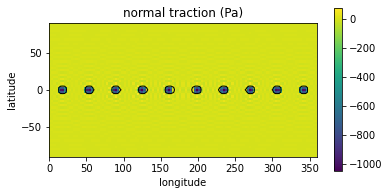

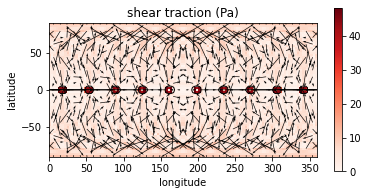

In [56]:
N = GLQCartCoord(lJmax)
X0 = N
lKmax = lJmax

dtheta = np.arctan(a/((R0+r0-d0)-np.sqrt(r0**2-a**2)))
cosdt  = np.cos(dtheta)
print(np.rad2deg(dtheta), dtheta, cosdt)

pL = np.array([0,-1, 0])
pR = np.array([0, 1, 0])

cos_XpL = np.dot(X0, pL)
cos_XpR = np.dot(X0, pR)

cLind = cos_XpL > cosdt
cRind = cos_XpR > cosdt

tS = np.arange(0, 1, 0.1)*np.pi*2
pS = np.vstack([np.sin(tS), np.cos(tS), 0*tS]).T
print(pS)

T0mesh = np.zeros_like(X0)
for i in range(tS.size):
    cSind = np.dot(X0, pS[i, :]) > cosdt
    T0mesh[cSind, :] = -(p0 * np.sqrt(1 - R0**2*(1-np.dot(X0[cSind, :], pS[i, :])**2)/(R0**2*(1-cosdt**2))))[:, None] * pS[i, :][None, :]
T0vec = SHmesh2Vec(T0mesh)
# print(T0mesh[np.nonzero(T0mesh)])

Vr, Vtheta, Vphi = CartCoord_to_SphCoord(X0[...,0], X0[...,1], X0[...,2])
LONS = np.rad2deg(Vphi).reshape(lmax_plot+1, 2*lmax_plot+2)
LATS = 90 - np.rad2deg(Vtheta).reshape(lmax_plot+1, 2*lmax_plot+2)
if plot_figure:
    fig, axs = visSHVec(T0vec*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, show=False,
                        config_quiver=(2, 3, 'k', 100), lonshift=180, figsize=(6,3))
    axs[0].contour(LONS, LATS, np.linalg.norm(T0mesh, axis=-1)*mu0, [mu0/2,], colors='k', linewidths=1)
    axs[1].contour(LONS, LATS, np.linalg.norm(T0mesh, axis=-1)*mu0, [mu0/2,], colors='k', linewidths=1)
    axs[0].set_title('normal traction (Pa)')
    axs[1].set_title('shear traction (Pa)')

    plt.show()

In [57]:
U0vec = Tvec2Uvec(T0vec, Cmat=Cmat, Dmat=Dmat)

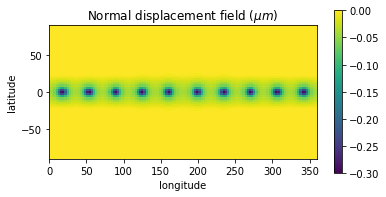

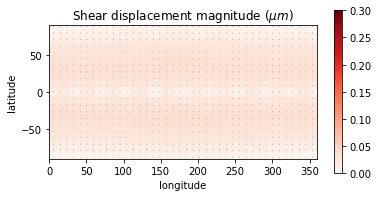

In [58]:
if plot_figure:
    fig, ax = visSHVec(U0vec*R, lmax_plot=lmax_plot, SphCoord=True, Complex=True, show=False,
                       config_quiver=(2, 3, 'k', 10), n_vrange=[-0.3, 0], s_vrange=[0, 0.3], lonshift=180, figsize=(6,3))
    ax[0].set_title('Normal displacement field ($\mu m$)')
    ax[1].set_title('Shear displacement magnitude ($\mu m$)')
    fig[0].savefig('ndisp.eps')
    fig[1].savefig('sdisp.eps')
    plt.show()

(61,) (121,)
(61, 122, 3)
[-0.04154335 -0.0414828  -0.04074764 -0.03969813 -0.04049747 -0.04076352
 -0.0402368  -0.03917823 -0.03962368 -0.04027529]
[-0.29230611 -0.29228082 -0.2894596  -0.28984577 -0.28807524 -0.28807524
 -0.28984577 -0.2894596  -0.29228082 -0.29230611]
-0.11848038582744067


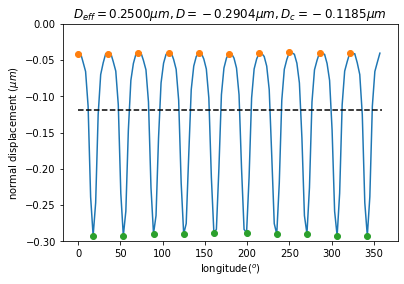

In [59]:
latitude, longitude = pyshtools.expand.GLQGridCoord(lJmax)
print(latitude.shape, longitude.shape)
U0mesh = SHVec2mesh(U0vec, Complex=True).real*R
print(U0mesh.shape)

deq  = U0mesh[latitude.size//2, :-1, 0]
topid= np.array([0, 12, 24, 36, 48, 60, 72, 84, 96, 108, ]).astype(int)
botid= np.array([6, 18, 30, 42, 54, 67, 79, 91,103, 115, ]).astype(int)
dtop = deq[topid]
dbot = deq[botid]
print(dtop)
print(dbot)

constriction = U0mesh[latitude.size//2, :-1, 0].mean()
print(constriction)

if plot_figure:
    plt.plot(longitude, deq)
    plt.plot(longitude[topid], deq[topid], 'o')
    plt.plot(longitude[botid], deq[botid], 'o')
    plt.plot([0,360], np.ones(2)*constriction, '--k')
    plt.xlabel('longitude($^o$)')
    plt.ylabel(r'normal displacement ($\mu m$)')
    plt.title(r'$D_{eff} = %.4f \mu m, D = %.4f \mu m, D_c = %.4f \mu m$'%(dtop.mean()-dbot.mean(), dbot.mean(), constriction))
    plt.ylim([-.3, 0])
    plt.show()

In [60]:
umesh_fine_scaled = SHVec2mesh(U0vec, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh_fine = SHVec2mesh(T0vec*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


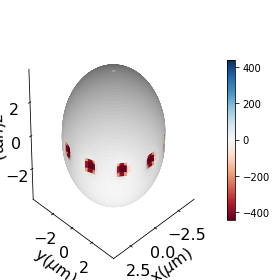

In [ ]:
if plot_figure:
    fig, ax = visSH3d(umesh_fine_scaled, cmesh=tmesh_fine, r0=R, show=False, colorbar=True,
                      elevation=30, azimuth=45, surface=True, figsize=plt.figaspect(1))
    ax.grid(None)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xlabel(r'x($\mu$m)', fontsize=16)
    ax.set_ylabel(r'y($\mu$m)', fontsize=16)
    ax.set_zlabel(r'z($\mu$m)', fontsize=16)
    # fig.tight_layout()
    fig.savefig('indent.pdf')
    fig.savefig('indent.eps')
    fig.savefig('indent.png', dpi=300, transparent=True)
    plt.show()

In [61]:
from shelastic.shbv import fast_stress_solution
from shelastic.shbv import print_SH_mode
from scipy.sparse.linalg import lsqr
import time

print(lKmax, lJmax)

tic = time.time()
A = lsqr(Cmat, T0vec.transpose(), atol=0, btol=0, conlim=0, iter_lim=1e7)
toc = time.time()
print('Residual:', A[3], 'Time:', toc-tic)
A_sol = np.zeros_like(A[0])
A_sol[np.abs(A[0]) > 1e-8] = A[0][np.abs(A[0]) > 1e-8]
print('Solution Size:', A_sol.size)
index_sol = print_SH_mode(A_sol, m_dir=3)

60 60
Residual: 0.0008681845322135233 Time: 11.182356834411621
Solution Size: 11163
index: 1 (1, -1, 0) coeff: (-3.699830861135405-8.508150541689635e-11j)
index: 3 (1, 1, 0) coeff: (3.6998308612932345-8.60500234191643e-11j)
index: 4 (2, -2, 0) coeff: (0.0001686245933484445-1.2911184313473613e-16j)
index: 6 (2, 0, 0) coeff: (-0.0007139557188358519+4.6381892901401536e-17j)
index: 8 (2, 2, 0) coeff: (0.00016862459334730917+1.0910077906974e-16j)
index: 9 (3, -3, 0) coeff: (-8.12476558329519e-05-1.6938747401119207e-14j)
index: 11 (3, -1, 0) coeff: (-0.0029307998762534704+4.3168757177553e-15j)
index: 13 (3, 1, 0) coeff: (0.002930799876241457+5.191231395703324e-15j)
index: 15 (3, 3, 0) coeff: (8.124765589655743e-05-2.010257682584736e-14j)
index: 16 (4, -4, 0) coeff: (-3.373697356405746e-05+2.6422724263705034e-17j)
index: 18 (4, -2, 0) coeff: (-2.9660993447133602e-05-2.337088993165222e-16j)
index: 20 (4, 0, 0) coeff: (0.0001219798605335875-3.1803991203268354e-16j)
index: 22 (4, 2, 0) coeff: (-

In [73]:
# define a coordinates on a sphere below the surface (by 1um)

latglq, longlq = pyshtools.expand.GLQGridCoord(lJmax, extend=True)
theta = np.deg2rad([90, ]) #90 - latglq)
phi = np.deg2rad(longlq)
print(theta.shape, phi.shape)

THETA,PHI = np.meshgrid(theta, phi)
RR = np.ones_like(THETA) * (R - 1) / R
XX, YY, ZZ = SphCoord_to_CartCoord(RR, THETA, PHI)
N = -np.stack((XX/RR, YY/RR, ZZ/RR), axis=-1)
print(XX.shape, N.shape)

(1,) (122,)
(122, 1) (122, 1, 3)


(122, 1, 3, 3) 3.974019765853882
(122, 1, 3)
(121, 3)


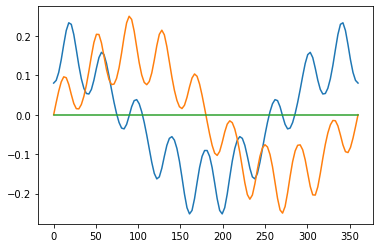

In [74]:
# solve the traction on the internal surface

from shelastic.shbv import fast_stress_solution, fast_displacement_solution

tic = time.time()
sigma_tot = fast_stress_solution(A_sol, XX, YY, ZZ, Smodes, lKmax, lJmax, shtype=shtype, verbose=True)
toc = time.time()
print(sigma_tot.shape, toc-tic)

(122, 1)
(122,)


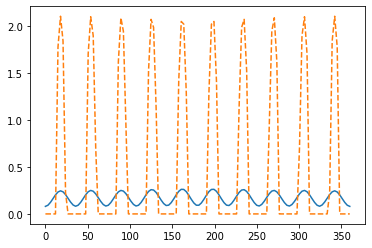

In [78]:
T_sol = np.linalg.norm(np.sum(sigma_tot*N[...,np.newaxis,:], axis=-1), axis=-1)
print(T_sol.shape)

T0sol = np.linalg.norm(T0mesh[latitude.size//2, :, :], axis=-1)
print(T0sol.shape)

fig, ax = plt.subplots()
ax.plot(longlq, T_sol[:, 0])
ax.plot(longlq, T0sol, '--')
plt.show()

# for k in range(3):
#     T_sol_grid = pyshtools.SHGrid.from_array(T_sol[...,k].T, grid='GLQ')
#     fig, ax = plotfv(T_sol_grid.to_array())
    #T_sol_grid.plot()#3d(elevation=20, azimuth=-45)

0.2 122.83418328768012
0.4 109.35731714786027
0.6000000000000001 106.77817180736835
0.8 107.64927951146532
1.0 109.03277483226452
1.2000000000000002 110.2332121702939
1.4000000000000001 111.16673034516185
1.6 111.88241944719384
1.8 112.43832319354786


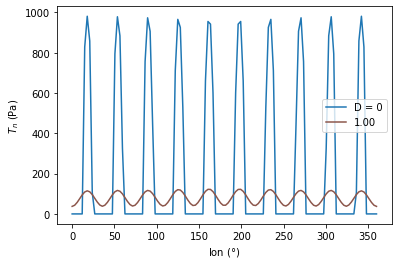

In [84]:
fig, ax = plt.subplots()
ax.plot(longlq, T0sol*mu0, '-C0', label='D = 0')

Tmax = [T0sol.max(), ]

dr_surf_list = np.arange(0.0, 2, 0.2)
for idr, dr_surf in enumerate(dr_surf_list):
    if idr == 0:
        continue
    RR = np.ones_like(THETA) * (R - dr_surf) / R
    XX, YY, ZZ = SphCoord_to_CartCoord(RR, THETA, PHI)
    N = -np.stack((XX/RR, YY/RR, ZZ/RR), axis=-1)
    sigma_tot = fast_stress_solution(A_sol, XX, YY, ZZ, Smodes, lKmax, lJmax, shtype=shtype, verbose=False)
    T_sol = np.linalg.norm(np.sum(sigma_tot*N[...,np.newaxis,:], axis=-1), axis=-1)
    if idr == 5:
        ax.plot(longlq, T_sol[:, 0]*mu0, 'C%d'%idr, label='%.2f'%dr_surf)
    print(dr_surf, np.linalg.norm(T_sol-T0sol))
    Tmax.append(T_sol.max())
ax.legend()
ax.set_xlabel('lon ($\degree$)')
ax.set_ylabel('$T_n$ (Pa)')
plt.show()

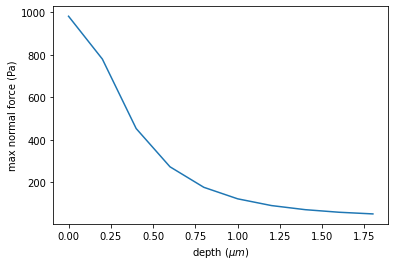

In [85]:
fig, ax = plt.subplots()
ax.plot(dr_surf_list, np.multiply(Tmax, mu0))
ax.set_xlabel('depth ($\mu m$)')
ax.set_ylabel('max normal force (Pa)')
plt.show()

0.2 15.482089030246122
0.4 15.737276878924595
0.6000000000000001 16.025259458800836
0.8 16.279078702646785
1.0 16.493142660958508
1.2000000000000002 16.675909907245874
1.4000000000000001 16.836037061643914
1.6 16.97976165027091
1.8 17.111244555615183


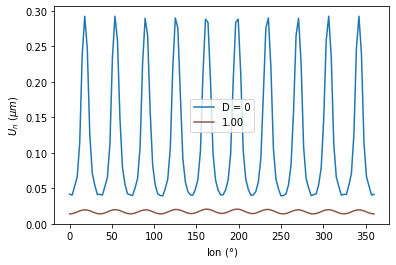

In [92]:
from shelastic.shbv import fast_stress_solution, fast_displacement_solution

U0sol = np.linalg.norm(U0mesh[latitude.size//2, :, :], axis=-1)

# print(U0sol.shape)
fig, ax = plt.subplots()
ax.plot(longlq, U0sol, '-C0', label='D = 0')

Umax = [U0sol.max(), ]

dr_surf_list = np.arange(0.0, 2, 0.2)
for idr, dr_surf in enumerate(dr_surf_list):
    if idr == 0:
        continue
    RR = np.ones_like(THETA) * (R - dr_surf) / R
    XX, YY, ZZ = SphCoord_to_CartCoord(RR, THETA, PHI)
    N = -np.stack((XX/RR, YY/RR, ZZ/RR), axis=-1)
    U_tot = fast_displacement_solution(A_sol, XX, YY, ZZ, Dmat, lKmax, lJmax, shtype=shtype)
    U_sol = np.linalg.norm(U_tot, axis=-1)
    if idr == 5:
        ax.plot(longlq, U_sol[:, 0], 'C%d'%idr, label='%.2f'%dr_surf)
    print(dr_surf, np.linalg.norm(U_sol-U0sol))
    Umax.append(U_sol.max())
ax.legend()
ax.set_xlabel('lon ($\degree$)')
ax.set_ylabel('$U_n$ ($\mu m$)')
plt.show()

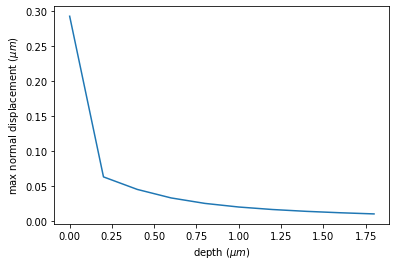

In [93]:
fig, ax = plt.subplots()
ax.plot(dr_surf_list, Umax)
ax.set_xlabel('depth ($\mu m$)')
ax.set_ylabel('max normal displacement ($\mu m$)')
plt.show()